In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
ds = pd.read_csv('train.csv')

In [4]:
columns = ds.columns
columns

Index(['is_profit', 'sym', 'datetime', 'rsi14', 'sma9_var', 'sma180_var',
       'vwap_var', 'spread14_e', 'volume14_34_var', 'prev_close_var',
       'prev_floor_var', 'prev_ceil_var', 'prev1_candle_score',
       'prev2_candle_score', 'prev3_candle_score', 'mins_from_start',
       'valley_interval_mins', 'valley_close_score', 'valley_rsi_score',
       'day_open_var', 'open_from_prev_close_var', 'ceil_var', 'floor_var'],
      dtype='object')

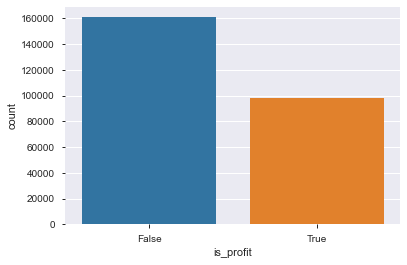

In [5]:
sns.countplot(ds.is_profit);

In [6]:
ds.head(3)

,is_profit,sym,datetime,rsi14,sma9_var,sma180_var,vwap_var,spread14_e,volume14_34_var,prev_close_var,...,prev2_candle_score,prev3_candle_score,mins_from_start,valley_interval_mins,valley_close_score,valley_rsi_score,day_open_var,open_from_prev_close_var,ceil_var,floor_var
0,True,MGNX,2020-11-02 11:13:00,30.509761,-0.006223,-0.022679,-0.017526,0.000620,-0.006472,-0.037037,...,0.000000,0.000000,103.0,50.0,0.425532,0.758046,-0.032058,-0.005144,-0.034554,0.000802
1,True,MGNX,2020-11-02 13:55:00,46.452741,-0.001062,-0.004721,-0.007713,0.000695,0.280249,-0.031893,...,0.001062,0.000504,265.0,67.0,0.633584,10.958588,-0.026887,-0.005144,-0.029397,0.006148
2,True,AEIS,2020-11-02 14:08:00,34.336224,-0.004443,-0.016648,-0.016589,0.000518,0.284800,0.011396,...,-0.001020,0.000000,278.0,13.0,0.306356,2.964667,-0.003935,0.015391,-0.030638,0.000000


In [7]:
ds.sym.unique().shape

(2610,)

In [8]:
def plot_hist_boxplot(data, col=columns[3:]):
    plt.figure(figsize=(18, 35))
    for i, feature in enumerate(col):
        plt.subplot(10, 4, i*2+1)
        plt.hist(data[feature], bins=50)
        plt.title(feature)
        plt.subplot(10, 4, i*2+2)
        plt.boxplot(data[feature])
        plt.title(feature)

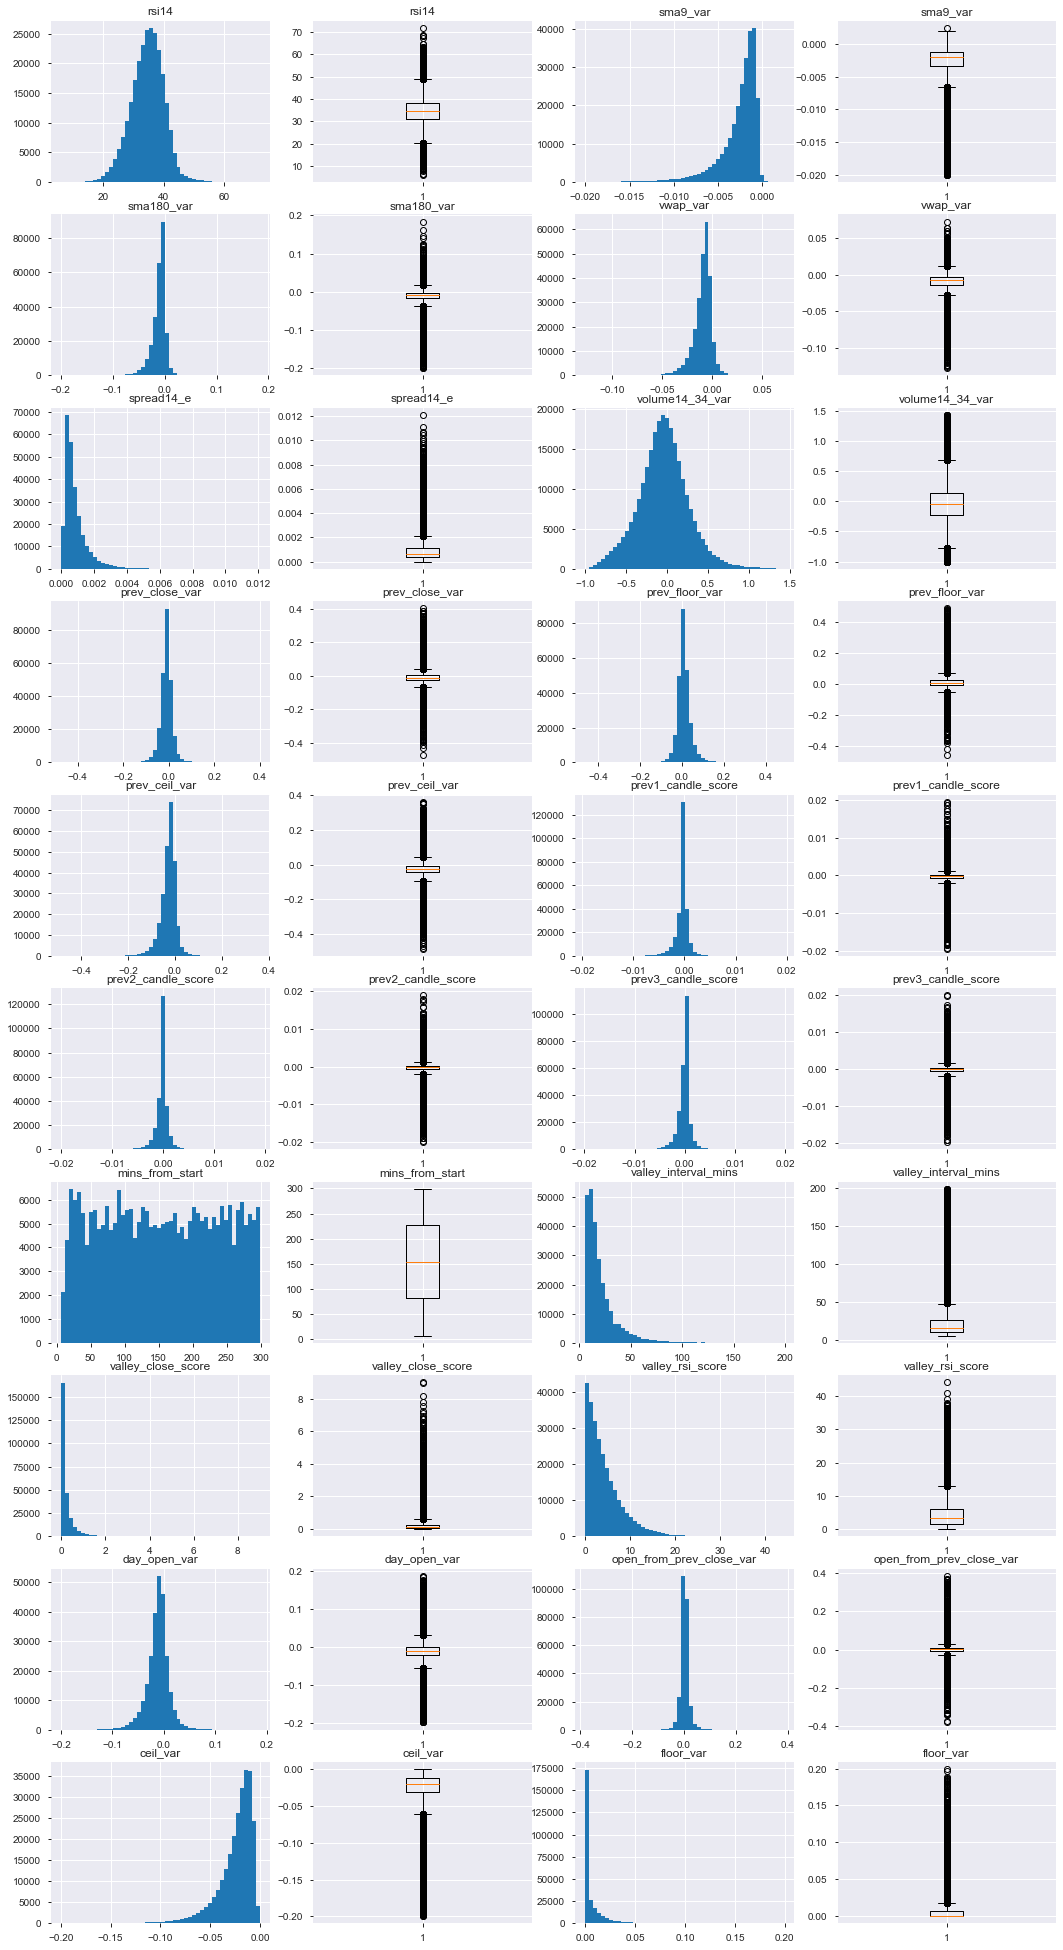

In [9]:
plot_hist_boxplot(data=ds, col=columns[3:])

In [10]:
columns_log = ['spread14_e', 'valley_interval_mins', 'valley_close_score', 'valley_rsi_score']

In [11]:
def replace_outlier(data, treshold=3):
    
    df = data.copy(deep=True)
    
    for col in list(df.columns):
        
        IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
        lower_fence = df[col].quantile(0.25) - IQR * treshold
        upper_fence = df[col].quantile(0.75) + IQR * treshold
        
        index_below_lower = df[col][df[col] < lower_fence].index
        index_above_upper = df[col][df[col] > upper_fence].index
        
        df[col][index_below_lower] = lower_fence
        df[col][index_above_upper] = upper_fence
        
    return df

In [12]:
df_log = ds.copy(deep=True)

In [13]:
df_log[columns_log] = np.log(df_log[columns_log])

In [14]:
ds_log_free_outlier = replace_outlier(df_log[columns[3:]], treshold=3)

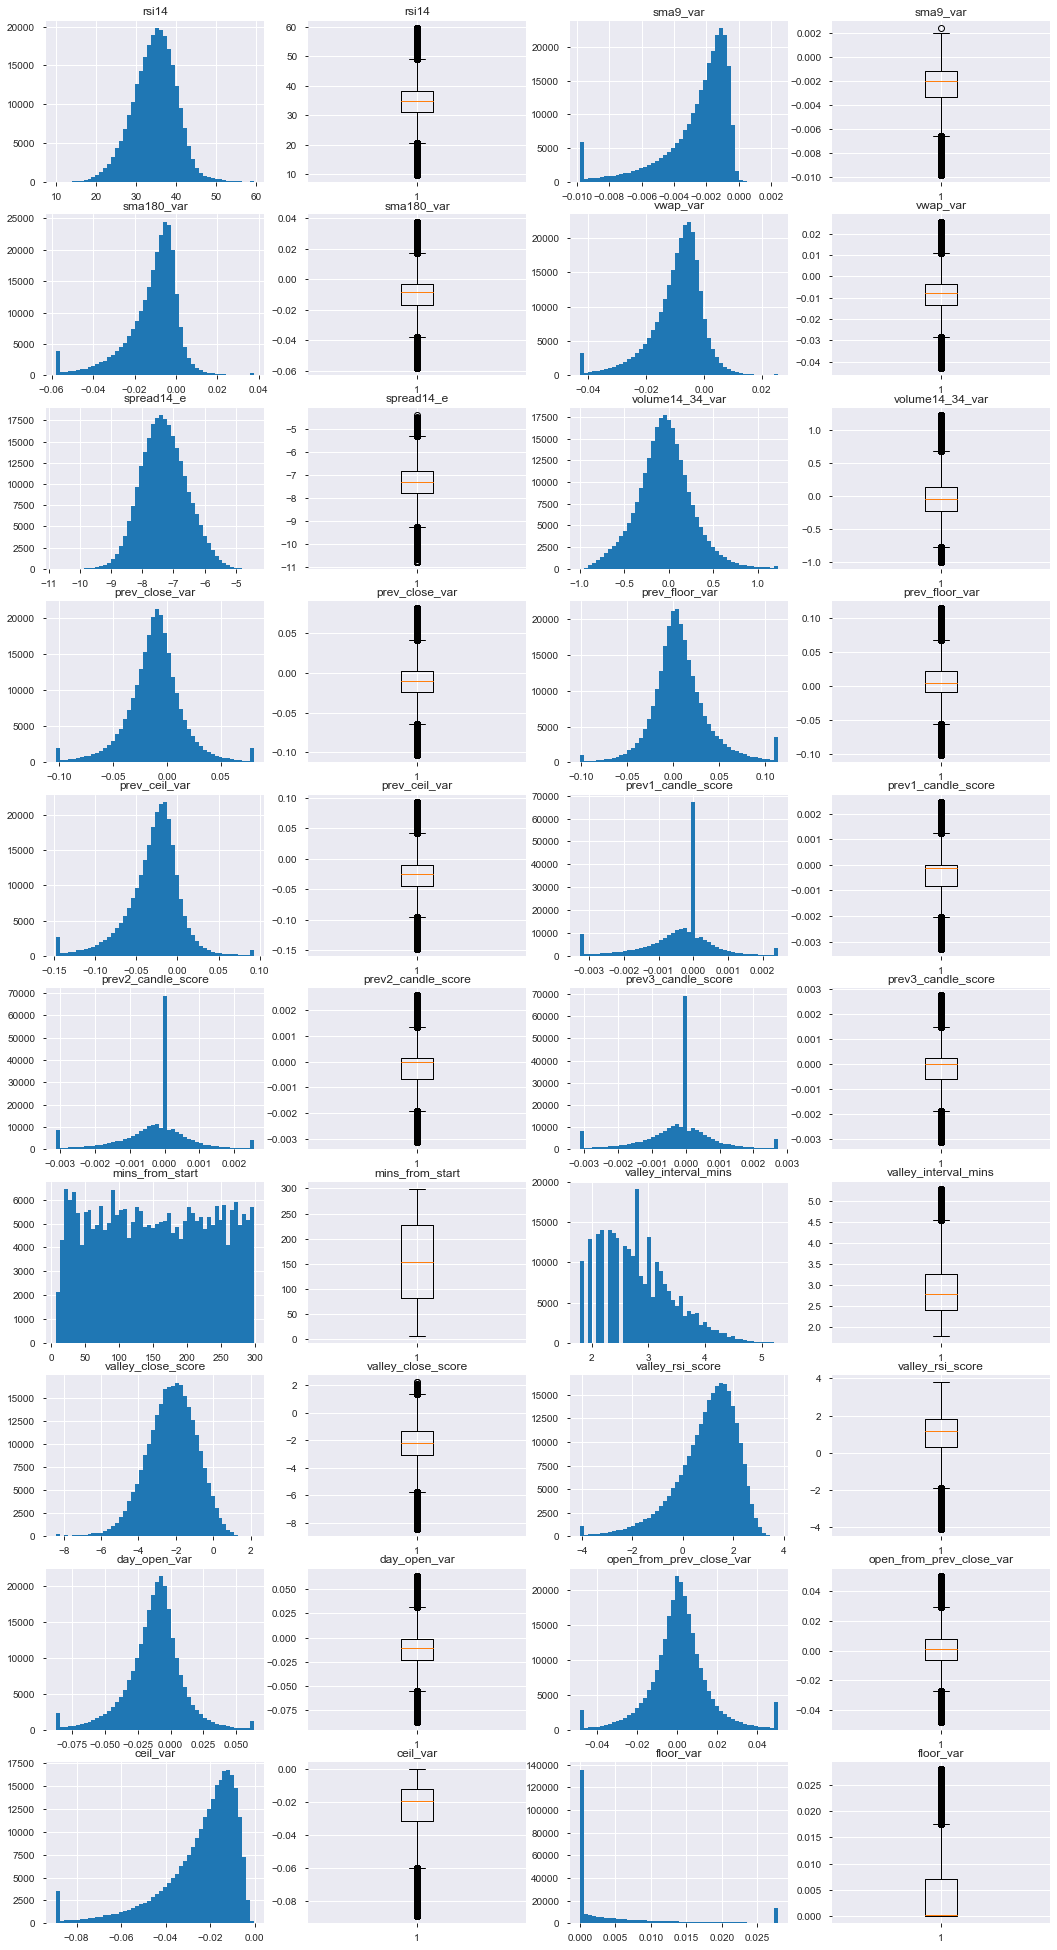

In [15]:
plot_hist_boxplot(data=ds_log_free_outlier)

In [16]:
def drop_outlier(data, treshold=3):
    
    df = data.copy(deep=True)
    
    for col in list(df.columns):
        
        IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
        lower_fence = df[col].quantile(0.25) - IQR * treshold
        upper_fence = df[col].quantile(0.75) + IQR * treshold
        
        index_below_lower = df[col][df[col] < lower_fence].index
        index_above_upper = df[col][df[col] > upper_fence].index
        
        df.drop(index=index_below_lower, inplace=True)
        df.drop(index=index_above_upper, inplace=True)              
        
    return df

In [17]:
ds_log_drop_outlier = drop_outlier(df_log[columns[3:]], treshold=3)

In [18]:
ds_log_drop_outlier.shape, ds.shape, ds_log_drop_outlier.shape[0] / ds.shape[0]

((206029, 20), (258729, 23), 0.7963119712131226)

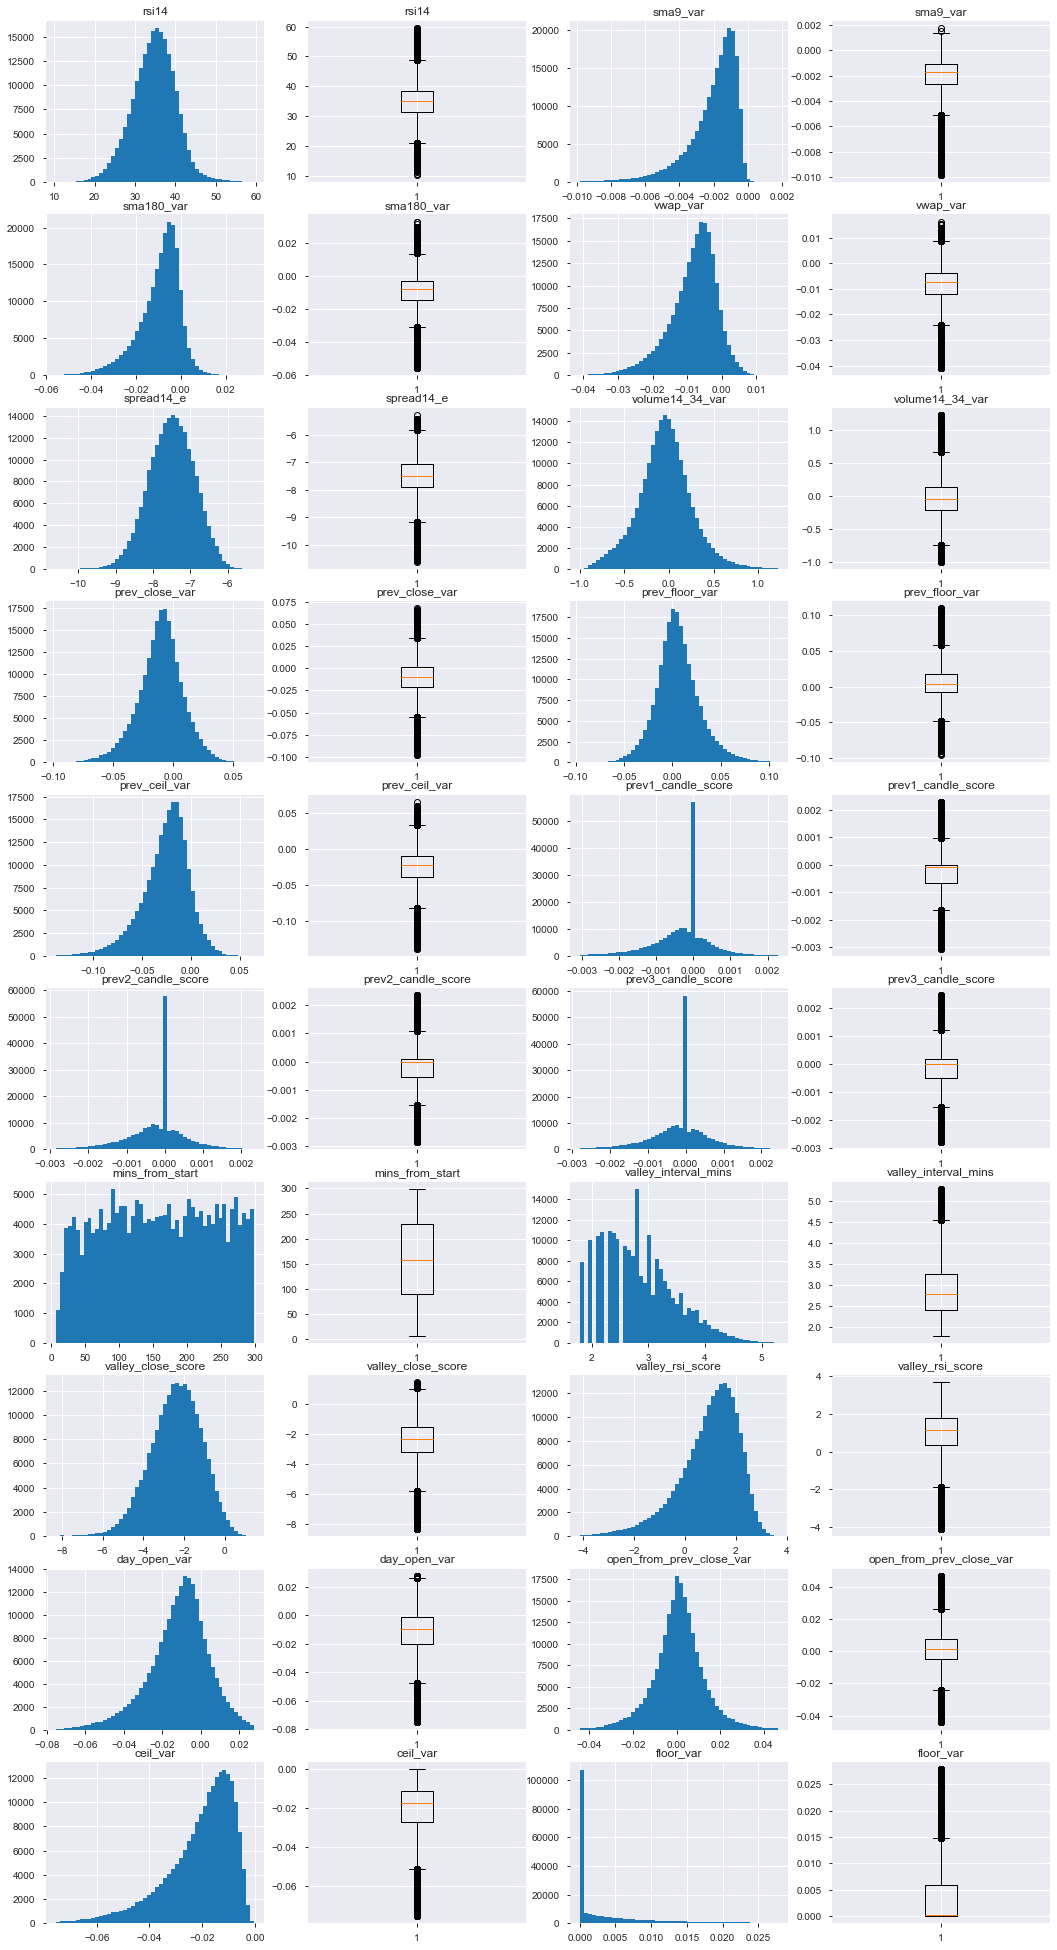

In [19]:
plot_hist_boxplot(data=ds_log_drop_outlier)

In [20]:
columns_other = [col for col in ds.columns if col not in (columns_log and columns[3:])]

In [21]:
columns_other

['is_profit', 'sym', 'datetime']

In [22]:
ds.sort_values(by=['datetime'], inplace=True)

In [23]:
date = ds.datetime.values

In [24]:
date

array(['2020-06-29 09:38:00', '2020-06-29 09:41:00',
       '2020-06-29 09:41:00', ..., '2021-01-22 14:29:00',
       '2021-01-22 14:29:00', '2021-01-22 14:29:00'], dtype=object)

### ------- add columns "day of week" -----------------

In [25]:
import datetime
import calendar

In [26]:
def split_to_lolumns_date(data):
    
    year_month_day = [d.split()[0] for d in data]
    d_time = [d.split()[1] for d in data]
    
    year = []
    month = []
    day = []
    hour = []
    minutes = []
    weekday = []
    
    year = [int(d.split('-')[0]) for d in year_month_day]
    month = [int(d.split('-')[1]) for d in year_month_day]
    day = [int(d.split('-')[2]) for d in year_month_day]
    hour = [int(d.split(':')[0]) for d in d_time]
    minutes = [int(d.split(':')[1]) for d in d_time]    
    weekday = [datetime.datetime(d[0], d[1], d[2]).weekday() for d in zip(year, month, day)]    
            
    df_date = pd.DataFrame({'year': year, 'month': month, 'day': day, 'hour': hour, 
                            'minutes': minutes, 'weekday': weekday})
    
    return df_date

In [27]:
df_date = split_to_lolumns_date(date)

In [28]:
df_date.shape, ds.shape

((258729, 6), (258729, 23))

In [29]:
df_date

,year,month,day,hour,minutes,weekday
0,2020,6,29,9,38,0
1,2020,6,29,9,41,0
2,2020,6,29,9,41,0
3,2020,6,29,9,42,0
4,2020,6,29,9,42,0
...,...,...,...,...,...,...
258724,2021,1,22,14,29,4
258725,2021,1,22,14,29,4
258726,2021,1,22,14,29,4
258727,2021,1,22,14,29,4


In [30]:
df_1 = pd.concat([df_date, ds.drop(['datetime', 'sym'], axis=1)], axis=1)

In [31]:
df_1

,year,month,day,hour,minutes,weekday,is_profit,rsi14,sma9_var,sma180_var,...,prev2_candle_score,prev3_candle_score,mins_from_start,valley_interval_mins,valley_close_score,valley_rsi_score,day_open_var,open_from_prev_close_var,ceil_var,floor_var
0,2020,6,29,9,38,0,True,30.509761,-0.006223,-0.022679,...,0.000000,0.000000,103.0,50.0,0.425532,0.758046,-0.032058,-0.005144,-0.034554,0.000802
1,2020,6,29,9,41,0,True,46.452741,-0.001062,-0.004721,...,0.001062,0.000504,265.0,67.0,0.633584,10.958588,-0.026887,-0.005144,-0.029397,0.006148
2,2020,6,29,9,41,0,True,34.336224,-0.004443,-0.016648,...,-0.001020,0.000000,278.0,13.0,0.306356,2.964667,-0.003935,0.015391,-0.030638,0.000000
3,2020,6,29,9,42,0,False,36.584676,-0.001006,0.005697,...,-0.000210,0.000000,110.0,8.0,0.042142,2.599359,0.003596,0.013725,-0.014746,0.003596
4,2020,6,29,9,42,0,True,29.113480,-0.000950,0.002626,...,-0.000012,0.000000,229.0,29.0,0.224383,0.091923,0.008738,0.010651,-0.016754,0.011470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258724,2021,1,22,14,29,4,False,32.602899,-0.002293,-0.033872,...,0.000000,-0.000590,85.0,19.0,0.118066,7.540690,-0.021400,-0.008601,-0.030373,0.000000
258725,2021,1,22,14,29,4,False,37.355860,-0.002370,-0.021928,...,0.001488,0.000209,247.0,46.0,0.563293,10.917935,-0.030075,-0.008601,-0.038968,0.000000
258726,2021,1,22,14,29,4,True,41.550637,-0.001991,-0.014774,...,0.000000,0.003775,285.0,20.0,0.077993,1.535276,0.070815,-0.012065,-0.037562,0.070815
258727,2021,1,22,14,29,4,False,35.433061,-0.005427,-0.012600,...,-0.001341,0.002687,146.0,12.0,0.235696,4.331218,0.003386,0.001356,-0.033909,0.003386


In [32]:
target = ds.is_profit

### ----------metrics-----------

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_auc_score, f1_score, roc_curve, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [34]:
def print_metrics(true, pred):
    print('accuracy: {}'.format(accuracy_score(true, pred)))
    print('MSE: {}'.format(mean_squared_error(true, pred)))   
    print('MAE: {}'.format(mean_absolute_error(true, pred)))
    print('f1 score: {}'.format(f1_score(true, pred)))
    print('precision score: {}'.format(precision_score(true, pred)))
    print('recall score: {}'.format(recall_score(true, pred)))

In [35]:
def plot_roc_auc(true, pred, title=''):
    
    fpr, tpr, threshold  = roc_curve(true, pred)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr)
    plt.title('{} ROC {:4f}'.format(title, roc_auc))
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Rositive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [36]:
def feature_importance(columns, coef):
    featureImportance = pd.DataFrame({'feature': columns, 'importance': coef})
    featureImportance.set_index('feature', inplace=True)
    featureImportance.sort_values(['importance'], ascending=False, inplace=True)
    
    return featureImportance

### ---------- Random Forest ----------------------------

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
size_train = int(df_1.shape[0] * 0.7)
size_train

181110

In [154]:
X_train = df_1.drop(['is_profit', 'weekday', 'hour', 'month', 'year', 'day', 'minutes', 
                     'valley_rsi_score', 'valley_interval_mins', 'rsi14', 'volume14_34_var'], axis=1)[size_train:]
X_test = df_1.drop(['is_profit', 'weekday', 'hour', 'month', 'year', 'day', 'minutes', 
                   'valley_rsi_score', 'valley_interval_mins', 'rsi14', 'volume14_34_var'], axis=1)[:size_train]

y_train = df_1['is_profit'][size_train:]
y_test = df_1['is_profit'][:size_train]

y_train.replace([True, False], [1, 0], inplace=True)
y_test.replace([True, False], [1, 0], inplace=True)

In [155]:
X_train.columns

Index(['sma9_var', 'sma180_var', 'vwap_var', 'spread14_e', 'prev_close_var',
       'prev_floor_var', 'prev_ceil_var', 'prev1_candle_score',
       'prev2_candle_score', 'prev3_candle_score', 'mins_from_start',
       'valley_close_score', 'day_open_var', 'open_from_prev_close_var',
       'ceil_var', 'floor_var'],
      dtype='object')

In [189]:
model_rf = RandomForestClassifier(n_estimators=1000, max_features=1, 
                                  bootstrap=True, 
                                  n_jobs=-1, random_state=42)

In [190]:
%%time
model_rf.fit(X_train, y_train)

CPU times: user 4min 34s, sys: 2.23 s, total: 4min 37s
Wall time: 37.5 s


RandomForestClassifier(max_features=1, n_estimators=1000, n_jobs=-1,
                       random_state=42)

In [191]:
y_pred_t = model_rf.predict(X_train)
y_pred_train = model_rf.predict_proba(X_train)

In [192]:
print_metrics(y_train, y_pred_t)

accuracy: 1.0
MSE: 0.0
MAE: 0.0
f1 score: 1.0
precision score: 1.0
recall score: 1.0


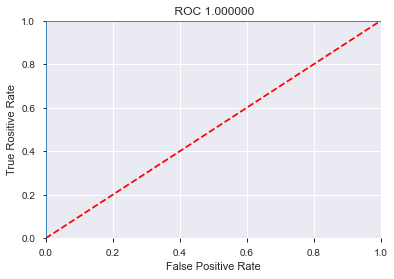

In [193]:
plot_roc_auc(y_train, y_pred_train[:, 1])

In [194]:
y_pred_tes = model_rf.predict(X_test)
y_pred_test = model_rf.predict_proba(X_test)

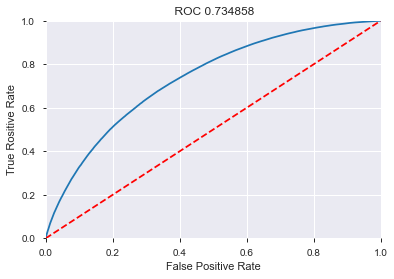

In [195]:
plot_roc_auc(y_test, y_pred_test[:, 1])

In [196]:
print_metrics(y_test, model_rf.predict(X_test))

accuracy: 0.6912318480481475
MSE: 0.3087681519518525
MAE: 0.3087681519518525
f1 score: 0.5443686702027979
precision score: 0.6183891449621444
recall score: 0.4861741762719758


In [197]:
featureImportance = feature_importance(X_train.columns, model_rf.feature_importances_)

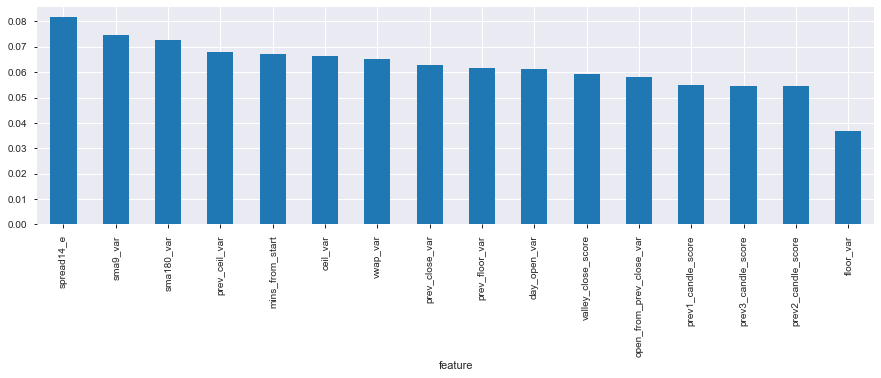

In [198]:
featureImportance.importance.plot(kind='bar', figsize=(15, 4));

### -------------- encoding categorical --------------------

In [38]:
from pandas import get_dummies

In [39]:
columns_numeric = df_1.columns[7:]
columns_numeric

Index(['rsi14', 'sma9_var', 'sma180_var', 'vwap_var', 'spread14_e',
       'volume14_34_var', 'prev_close_var', 'prev_floor_var', 'prev_ceil_var',
       'prev1_candle_score', 'prev2_candle_score', 'prev3_candle_score',
       'mins_from_start', 'valley_interval_mins', 'valley_close_score',
       'valley_rsi_score', 'day_open_var', 'open_from_prev_close_var',
       'ceil_var', 'floor_var'],
      dtype='object')

In [40]:
columns_categorical = [col for col in df_1.columns if col not in columns_numeric]
columns_categorical

['year', 'month', 'day', 'hour', 'minutes', 'weekday', 'is_profit']

In [41]:
df_to_model = df_1.copy(deep=True)
df_to_model.drop(['year', 'month', 'day', 'hour', 'minutes'], axis=1, inplace=True)

In [42]:
df_to_model.head(3)

,weekday,is_profit,rsi14,sma9_var,sma180_var,vwap_var,spread14_e,volume14_34_var,prev_close_var,prev_floor_var,...,prev2_candle_score,prev3_candle_score,mins_from_start,valley_interval_mins,valley_close_score,valley_rsi_score,day_open_var,open_from_prev_close_var,ceil_var,floor_var
0,0,True,30.509761,-0.006223,-0.022679,-0.017526,0.000620,-0.006472,-0.037037,-0.012658,...,0.000000,0.000000,103.0,50.0,0.425532,0.758046,-0.032058,-0.005144,-0.034554,0.000802
1,0,True,46.452741,-0.001062,-0.004721,-0.007713,0.000695,0.280249,-0.031893,-0.007384,...,0.001062,0.000504,265.0,67.0,0.633584,10.958588,-0.026887,-0.005144,-0.029397,0.006148
2,0,True,34.336224,-0.004443,-0.016648,-0.016589,0.000518,0.284800,0.011396,0.023360,...,-0.001020,0.000000,278.0,13.0,0.306356,2.964667,-0.003935,0.015391,-0.030638,0.000000


In [43]:
df_to_model = pd.get_dummies(data=df_to_model, columns=['weekday'], drop_first=True)

In [44]:
df_to_model

,is_profit,rsi14,sma9_var,sma180_var,vwap_var,spread14_e,volume14_34_var,prev_close_var,prev_floor_var,prev_ceil_var,...,valley_close_score,valley_rsi_score,day_open_var,open_from_prev_close_var,ceil_var,floor_var,weekday_1,weekday_2,weekday_3,weekday_4
0,True,30.509761,-0.006223,-0.022679,-0.017526,0.000620,-0.006472,-0.037037,-0.012658,-0.047328,...,0.425532,0.758046,-0.032058,-0.005144,-0.034554,0.000802,0,0,0,0
1,True,46.452741,-0.001062,-0.004721,-0.007713,0.000695,0.280249,-0.031893,-0.007384,-0.042239,...,0.633584,10.958588,-0.026887,-0.005144,-0.029397,0.006148,0,0,0,0
2,True,34.336224,-0.004443,-0.016648,-0.016589,0.000518,0.284800,0.011396,0.023360,-0.014706,...,0.306356,2.964667,-0.003935,0.015391,-0.030638,0.000000,0,0,0,0
3,False,36.584676,-0.001006,0.005697,-0.004279,0.000327,-0.514448,0.017371,0.023517,0.001266,...,0.042142,2.599359,0.003596,0.013725,-0.014746,0.003596,0,0,0,0
4,True,29.113480,-0.000950,0.002626,-0.001767,0.000286,-0.033291,0.019482,0.035230,-0.001628,...,0.224383,0.091923,0.008738,0.010651,-0.016754,0.011470,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258724,False,32.602899,-0.002293,-0.033872,-0.011582,0.001114,0.462271,-0.029817,-0.028145,-0.060000,...,0.118066,7.540690,-0.021400,-0.008601,-0.030373,0.000000,0,0,0,1
258725,False,37.355860,-0.002370,-0.021928,-0.015194,0.000470,-0.238875,-0.038417,-0.036760,-0.068333,...,0.563293,10.917935,-0.030075,-0.008601,-0.038968,0.000000,0,0,0,1
258726,True,41.550637,-0.001991,-0.014774,-0.003803,0.000993,-0.062510,0.057895,0.105147,0.050330,...,0.077993,1.535276,0.070815,-0.012065,-0.037562,0.070815,0,0,0,1
258727,False,35.433061,-0.005427,-0.012600,-0.015767,0.001918,0.046143,0.004747,0.015770,-0.095270,...,0.235696,4.331218,0.003386,0.001356,-0.033909,0.003386,0,0,0,1


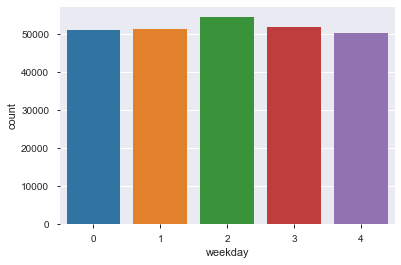

In [45]:
sns.countplot(df_1.weekday)

In [46]:
df_to_model.is_profit = [1 if v == True else 0 for v in df_1.is_profit]

In [47]:
df_to_model

,is_profit,rsi14,sma9_var,sma180_var,vwap_var,spread14_e,volume14_34_var,prev_close_var,prev_floor_var,prev_ceil_var,...,valley_close_score,valley_rsi_score,day_open_var,open_from_prev_close_var,ceil_var,floor_var,weekday_1,weekday_2,weekday_3,weekday_4
0,1,30.509761,-0.006223,-0.022679,-0.017526,0.000620,-0.006472,-0.037037,-0.012658,-0.047328,...,0.425532,0.758046,-0.032058,-0.005144,-0.034554,0.000802,0,0,0,0
1,1,46.452741,-0.001062,-0.004721,-0.007713,0.000695,0.280249,-0.031893,-0.007384,-0.042239,...,0.633584,10.958588,-0.026887,-0.005144,-0.029397,0.006148,0,0,0,0
2,1,34.336224,-0.004443,-0.016648,-0.016589,0.000518,0.284800,0.011396,0.023360,-0.014706,...,0.306356,2.964667,-0.003935,0.015391,-0.030638,0.000000,0,0,0,0
3,0,36.584676,-0.001006,0.005697,-0.004279,0.000327,-0.514448,0.017371,0.023517,0.001266,...,0.042142,2.599359,0.003596,0.013725,-0.014746,0.003596,0,0,0,0
4,1,29.113480,-0.000950,0.002626,-0.001767,0.000286,-0.033291,0.019482,0.035230,-0.001628,...,0.224383,0.091923,0.008738,0.010651,-0.016754,0.011470,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258724,0,32.602899,-0.002293,-0.033872,-0.011582,0.001114,0.462271,-0.029817,-0.028145,-0.060000,...,0.118066,7.540690,-0.021400,-0.008601,-0.030373,0.000000,0,0,0,1
258725,0,37.355860,-0.002370,-0.021928,-0.015194,0.000470,-0.238875,-0.038417,-0.036760,-0.068333,...,0.563293,10.917935,-0.030075,-0.008601,-0.038968,0.000000,0,0,0,1
258726,1,41.550637,-0.001991,-0.014774,-0.003803,0.000993,-0.062510,0.057895,0.105147,0.050330,...,0.077993,1.535276,0.070815,-0.012065,-0.037562,0.070815,0,0,0,1
258727,0,35.433061,-0.005427,-0.012600,-0.015767,0.001918,0.046143,0.004747,0.015770,-0.095270,...,0.235696,4.331218,0.003386,0.001356,-0.033909,0.003386,0,0,0,1


### -------------- train test --------

25% -> test

In [48]:
size_train = int(df_to_model.shape[0] * 0.7)
size_train

181110

In [49]:
X_train = df_to_model.drop(['is_profit'], axis=1)[:size_train]

In [50]:
X_test = df_to_model.drop(['is_profit'], axis=1)[size_train:]

In [51]:
X_test.shape[0] + X_train.shape[0], df_1.shape[0]

(258729, 258729)

In [52]:
y_train = df_to_model.is_profit[:size_train]
y_test = df_to_model.is_profit[size_train:]

In [53]:
y_train.shape[0] + y_test.shape[0], df_1.shape[0]

(258729, 258729)

In [54]:
X_train

,rsi14,sma9_var,sma180_var,vwap_var,spread14_e,volume14_34_var,prev_close_var,prev_floor_var,prev_ceil_var,prev1_candle_score,...,valley_close_score,valley_rsi_score,day_open_var,open_from_prev_close_var,ceil_var,floor_var,weekday_1,weekday_2,weekday_3,weekday_4
0,30.509761,-0.006223,-0.022679,-0.017526,0.000620,-0.006472,-0.037037,-0.012658,-0.047328,-0.002925,...,0.425532,0.758046,-0.032058,-0.005144,-0.034554,0.000802,0,0,0,0
1,46.452741,-0.001062,-0.004721,-0.007713,0.000695,0.280249,-0.031893,-0.007384,-0.042239,0.000000,...,0.633584,10.958588,-0.026887,-0.005144,-0.029397,0.006148,0,0,0,0
2,34.336224,-0.004443,-0.016648,-0.016589,0.000518,0.284800,0.011396,0.023360,-0.014706,0.000000,...,0.306356,2.964667,-0.003935,0.015391,-0.030638,0.000000,0,0,0,0
3,36.584676,-0.001006,0.005697,-0.004279,0.000327,-0.514448,0.017371,0.023517,0.001266,-0.000105,...,0.042142,2.599359,0.003596,0.013725,-0.014746,0.003596,0,0,0,0
4,29.113480,-0.000950,0.002626,-0.001767,0.000286,-0.033291,0.019482,0.035230,-0.001628,-0.000375,...,0.224383,0.091923,0.008738,0.010651,-0.016754,0.011470,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181105,34.097880,-0.001238,-0.012030,-0.017464,0.000573,0.046909,-0.094966,-0.086660,-0.112806,-0.000026,...,0.232521,3.931168,-0.051949,-0.045374,-0.053993,0.000169,0,0,0,0
181106,26.444678,-0.003663,-0.012583,-0.014437,0.001525,0.275140,0.004628,0.014187,-0.026152,-0.003188,...,0.123444,6.251404,0.009414,-0.004741,-0.038565,0.014129,0,0,0,0
181107,33.322248,-0.004198,-0.011651,-0.014784,0.001245,-0.324226,0.004064,0.013617,-0.026699,-0.002296,...,0.056183,6.877570,0.008847,-0.004741,-0.039106,0.013560,0,0,0,0
181108,24.167328,-0.004244,-0.038616,-0.009184,0.001257,-0.220435,-0.040911,-0.037293,-0.053212,-0.001116,...,0.601155,12.058579,-0.007436,-0.033725,-0.020077,0.000000,0,0,0,0


In [55]:
y_train

0         1
1         1
2         1
3         0
4         1
         ..
181105    1
181106    0
181107    0
181108    1
181109    1
Name: is_profit, Length: 181110, dtype: int64

### ----------------Scaler----------------------

In [56]:
scaler =StandardScaler()

In [57]:
X_train[columns_numeric] = scaler.fit_transform(X_train[columns_numeric])

In [58]:
X_train

,rsi14,sma9_var,sma180_var,vwap_var,spread14_e,volume14_34_var,prev_close_var,prev_floor_var,prev_ceil_var,prev1_candle_score,...,valley_close_score,valley_rsi_score,day_open_var,open_from_prev_close_var,ceil_var,floor_var,weekday_1,weekday_2,weekday_3,weekday_4
0,-0.722820,-1.567340,-0.736874,-0.809545,-0.341701,0.120558,-0.872160,-0.592718,-0.493605,-1.848039,...,0.553242,-0.896507,-0.879317,-0.317445,-0.543770,-0.441131,0,0,0,0
1,2.189269,0.690969,0.481384,0.185274,-0.241063,1.042802,-0.698434,-0.442094,-0.351527,0.341319,...,1.150810,1.638900,-0.647207,-0.317445,-0.261555,0.029165,0,0,0,0
2,-0.023891,-0.788690,-0.327750,-0.714498,-0.480912,1.057441,0.763517,0.435904,0.417150,0.341319,...,0.210945,-0.348038,0.383101,0.697142,-0.329506,-0.511672,0,0,0,0
3,0.386803,0.715244,1.188129,0.533446,-0.739483,-1.513355,0.965313,0.440372,0.863065,0.262473,...,-0.547929,-0.438837,0.721196,0.614811,0.540165,-0.195309,0,0,0,0
4,-0.977859,0.739649,0.979764,0.788017,-0.794606,0.034295,1.036623,0.774893,0.782275,0.060857,...,-0.024496,-1.062076,0.952017,0.462928,0.430267,0.497321,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181105,-0.067426,0.613583,-0.014468,-0.803199,-0.406004,0.292261,-2.828538,-2.706083,-2.321625,0.321935,...,-0.001123,-0.107808,-1.772236,-2.305041,-1.607514,-0.496813,0,0,0,0
181106,-1.465333,-0.447339,-0.051987,-0.496325,0.883916,1.026370,0.534966,0.173940,0.097607,-2.045121,...,-0.314414,0.468901,0.982335,-0.297527,-0.763286,0.731271,0,0,0,0
181107,-0.209100,-0.681418,0.011277,-0.531567,0.504558,-0.901501,0.515904,0.157667,0.082332,-1.377494,...,-0.507599,0.624538,0.956877,-0.297527,-0.792844,0.681149,0,0,0,0
181108,-1.881306,-0.701458,-1.818006,0.036119,0.521082,-0.567656,-1.002974,-1.296228,-0.657861,-0.494111,...,1.057668,1.912309,0.225939,-1.729523,0.248436,-0.511672,0,0,0,0


### -------------- baseline --------------------

In [220]:
X_train.shape, X_train.shape[0] * 0.1

((181110, 24), 18111.0)

let`s take 25 percent of the data

In [221]:
from sklearn.model_selection import GridSearchCV

In [222]:
model_LR = LogisticRegression()

In [223]:
params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 
         'C': [0.00001, 0.0001, 0.001, 0.01, 1, 10]}

In [224]:
model_GS_LogReg = GridSearchCV(estimator=model_LR, param_grid=params, 
                              cv=3, scoring='roc_auc', n_jobs=-1)

In [225]:
%%time
model_GS_LogReg.fit(X_train.drop(['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4'], axis=1), y_train)

CPU times: user 3.34 s, sys: 3.51 s, total: 6.85 s
Wall time: 20.8 s


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 1, 10],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             scoring='roc_auc')

In [226]:
model_GS_LogReg.best_estimator_

LogisticRegression(C=0.001)

In [227]:
model_GS_LogReg.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [228]:
y_pred_LR = model_GS_LogReg.best_estimator_.predict(X_train.drop(['weekday_1', 'weekday_2', 
                                                                  'weekday_3', 'weekday_4'], 
                                                                 axis=1))

In [229]:
print_metrics(y_train, y_pred_LR)

accuracy: 0.692181547126056
MSE: 0.307818452873944
MAE: 0.307818452873944
f1 score: 0.49146651828472915
precision score: 0.6584137846755469
recall score: 0.39205670043078356


In [230]:
model_GS_LogReg.best_estimator_.coef_

array([[ 0.05022243, -0.14514947, -0.08002772, -0.06364602,  0.1296657 ,
         0.00087195,  0.04747322,  0.29580218, -0.33634668,  0.02736919,
         0.01896283,  0.02038412, -0.45448485,  0.00721031,  0.00583094,
        -0.01063708,  0.02210374,  0.01532433, -0.35613836,  0.18758222]])

In [232]:
featureImportance = feature_importance(X_train.drop(['weekday_1', 'weekday_2', 
                                                     'weekday_3', 'weekday_4'], 
                                                   axis=1).columns, model_GS_LogReg.best_estimator_.coef_[0, :])

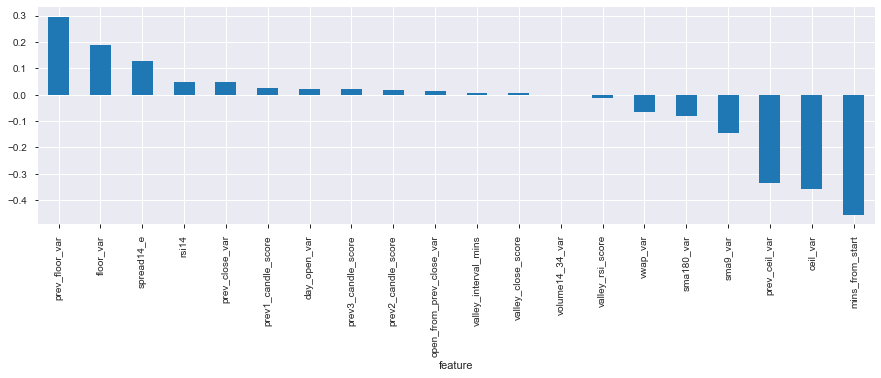

In [233]:
featureImportance.importance.plot(kind='bar', figsize=(15, 4));

In [234]:
featureImportance

,importance
feature,
prev_floor_var,0.295802
floor_var,0.187582
spread14_e,0.129666
rsi14,0.050222
prev_close_var,0.047473
prev1_candle_score,0.027369
day_open_var,0.022104
prev3_candle_score,0.020384
prev2_candle_score,0.018963


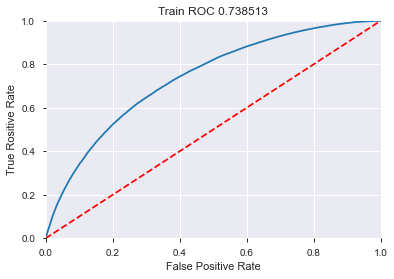

In [236]:
plot_roc_auc(y_train, model_GS_LogReg.best_estimator_.predict_proba(X_train.drop(['weekday_1', 'weekday_2', 
                                                                                 'weekday_3', 'weekday_4'], 
                                                                                axis=1))[:, 1], title='Train')

In [237]:
X_test[columns_numeric] = scaler.transform(X_test[columns_numeric])

In [238]:
y_pred_LR_test = model_GS_LogReg.best_estimator_.predict(X_test.drop(['weekday_1', 'weekday_2', 
                                                                      'weekday_3', 'weekday_4'], 
                                                                     axis=1))

In [239]:
print_metrics(y_test, y_pred_LR_test)

accuracy: 0.7018255839420761
MSE: 0.29817441605792394
MAE: 0.29817441605792394
f1 score: 0.5089118995077236
precision score: 0.6631276266312762
recall score: 0.4128907863930588


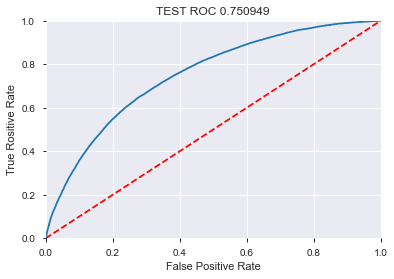

In [241]:
plot_roc_auc(y_test, model_GS_LogReg.best_estimator_.predict_proba(X_test.drop(['weekday_1', 'weekday_2', 
                                                                                'weekday_3', 'weekday_4'], 
                                                                               axis=1))[:, 1], title='TEST')

### ------- clear data --------------------

In [364]:
y_train[y_train == 1].shape, y_train[y_train == 0].shape

((68712,), (112398,))

In [365]:
count_leave = len(y_train[y_train == 1].index)
count_leave

68712

In [366]:
index_true = y_train[y_train == 1].index

In [367]:
index_false = y_train[y_train == 0].index

In [368]:
index_false_for_x_train = np.random.choice(index_false, count_leave)

In [369]:
X_train.loc[index_false_for_x_train]

,rsi14,sma9_var,sma180_var,vwap_var,spread14_e,volume14_34_var,prev_close_var,prev_floor_var,prev_ceil_var,prev1_candle_score,...,valley_close_score,valley_rsi_score,day_open_var,open_from_prev_close_var,ceil_var,floor_var,weekday_1,weekday_2,weekday_3,weekday_4
108079,-0.137393,-0.627955,0.166519,0.326575,1.016953,-1.488754,-0.006445,0.099205,0.425686,-0.133373,...,-0.070717,2.811752,0.071985,-0.090125,0.752463,-0.511672,0,0,0,0
8018,0.121683,-0.759299,-0.057423,1.512313,1.203985,-0.645591,6.408996,5.877882,5.598651,-0.094659,...,-0.207669,-0.659054,3.963920,4.654247,-1.186755,8.259706,0,0,0,0
173843,-0.683898,0.657938,0.151872,0.170352,-0.599287,0.202964,-0.933660,-1.145187,-0.576313,0.306888,...,-0.483930,-0.048015,-0.613917,-0.708234,-0.083662,-0.450873,1,0,0,0
116189,0.144221,-0.958022,0.167810,-0.490863,0.590351,-0.496033,-0.065705,-0.019233,-0.255116,-0.706321,...,-0.366942,-0.585014,-0.122741,0.039352,-0.165192,-0.511672,1,0,0,0
30872,-0.169996,0.763174,0.585392,0.705219,-0.770665,0.575111,0.698296,0.419291,1.084468,-0.051645,...,-0.522267,-0.337930,0.562588,0.401160,0.909681,-0.401033,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9681,1.574743,0.740944,0.705765,0.803741,-0.218593,-2.109331,0.330694,-0.231222,0.748512,0.341319,...,-0.260996,-0.786438,0.305785,0.147245,1.037470,-0.449060,1,0,0,0
48959,0.503159,0.033322,-0.436816,-0.287191,-0.605355,0.265030,-0.679575,-0.844019,-0.452403,1.040006,...,-0.624331,0.371850,-0.603119,-0.338682,-0.070499,-0.511672,0,0,0,0
124281,-1.017444,0.281691,0.202271,1.076451,0.114241,0.557024,1.224655,0.484157,0.234750,-0.042172,...,-0.179483,1.783005,1.673606,-0.051871,0.131127,2.940985,1,0,0,0
43891,-0.559117,0.194331,-0.541475,-1.353605,-0.236693,-1.031980,-0.614911,-0.490786,-0.253088,-0.354360,...,-0.340028,-0.994248,0.284811,-1.221311,-0.571319,-0.511672,0,1,0,0


In [370]:
X_train_undersampling = X_train.loc[index_true]
X_train_undersampling = X_train_undersampling.append(X_train.loc[index_false_for_x_train])

In [371]:
X_train_undersampling.shape

(137424, 24)

In [372]:
y_train_undersampling = y_train[index_true]
y_train_undersampling = y_train_undersampling.append(y_train[index_false_for_x_train])
y_train_undersampling.shape

(137424,)

In [373]:
X_train_undersampling.sort_index(inplace=True)
y_train_undersampling.sort_index(inplace=True)

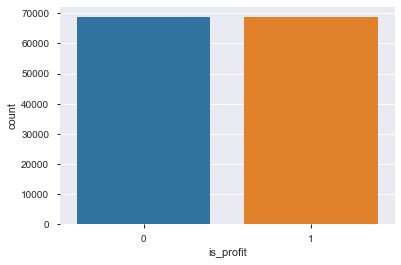

In [374]:
sns.countplot(y_train_undersampling);

In [375]:
False in (X_train_undersampling.index == y_train_undersampling.index)

False

In [295]:
model_LR = LogisticRegression(random_state=42)

In [296]:
params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'C': [0.00001, 0.0001, 0.001, 0.01, 1, 10]}

In [297]:
gs_LR = GridSearchCV(estimator=model_LR, param_grid=params, n_jobs=-1, cv=3, scoring='roc_auc')

In [303]:
%%time
gs_LR.fit(X_train_undersampling.drop(['weekday_1', 'weekday_2', 
                                      'weekday_3', 'weekday_4'], 
                                     axis=1), y_train_undersampling)

CPU times: user 2.67 s, sys: 184 ms, total: 2.86 s
Wall time: 8.55 s


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 1, 10],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             scoring='roc_auc')

In [334]:
%%time
model_LR = LogisticRegression(penalty='l2', C=0.001)
model_LR.fit(X_train_undersampling, y_train_undersampling)

CPU times: user 2.12 s, sys: 40 ms, total: 2.16 s
Wall time: 671 ms


LogisticRegression(C=0.001)

In [333]:
gs_LR.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [337]:
print_metrics(y_train_undersampling, model_LR.predict(X_train_undersampling))

accuracy: 0.6730993130748631
MSE: 0.3269006869251368
MAE: 0.3269006869251368
f1 score: 0.657779267475166
precision score: 0.6901214833759591
recall score: 0.6283327511933869


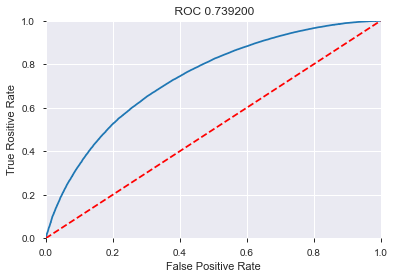

In [338]:
plot_roc_auc(y_train_undersampling, model_LR.predict_proba(X_train_undersampling)[:, 1])

In [340]:
print_metrics(y_test, model_LR.predict(X_test))

accuracy: 0.6959765005990801
MSE: 0.3040234994009199
MAE: 0.3040234994009199
f1 score: 0.6114660168598525
precision score: 0.5859207370945348
recall score: 0.6393403112518937


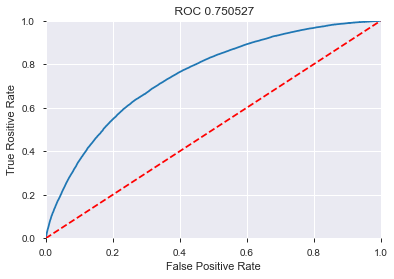

In [341]:
plot_roc_auc(y_test, model_LR.predict_proba(X_test)[:, 1])

In [342]:
featureImportance = feature_importance(X_train_undersampling, model_LR.coef_[0])

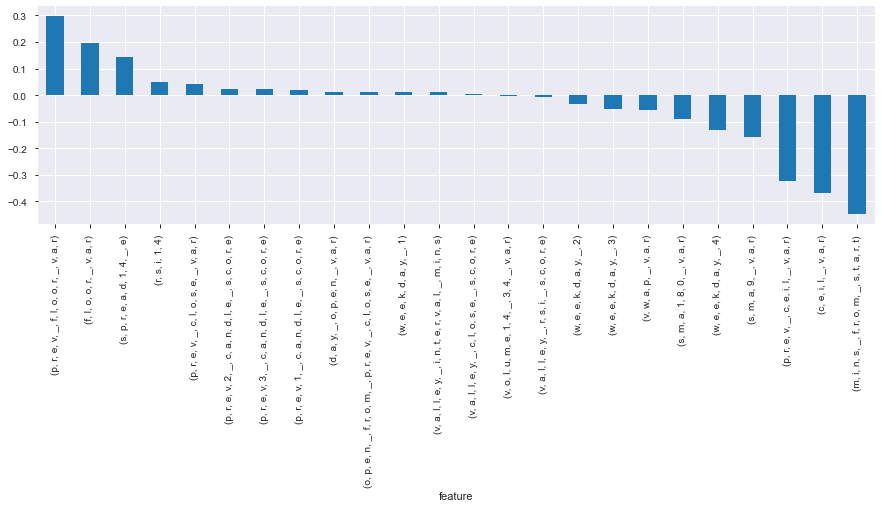

In [343]:
featureImportance.importance.plot(kind='bar', figsize=(15, 4))

In [377]:
X_train_undersampling_log = X_train_undersampling.copy(deep=True)
X_train_undersampling_log[columns_log] = np.log(X_train_undersampling[columns_log]+1)

In [378]:
X_train_undersampling_free_outlier = replace_outlier(X_train_undersampling)

In [379]:
index = X_train_undersampling_free_outlier.index

In [380]:
X_train_undersampling_free_outlier.isnull().sum()

rsi14                       0
sma9_var                    0
sma180_var                  0
vwap_var                    0
spread14_e                  0
volume14_34_var             0
prev_close_var              0
prev_floor_var              0
prev_ceil_var               0
prev1_candle_score          0
prev2_candle_score          0
prev3_candle_score          0
mins_from_start             0
valley_interval_mins        0
valley_close_score          0
valley_rsi_score            0
day_open_var                0
open_from_prev_close_var    0
ceil_var                    0
floor_var                   0
weekday_1                   0
weekday_2                   0
weekday_3                   0
weekday_4                   0
dtype: int64

In [381]:
model_LR.fit(X_train_undersampling_free_outlier, y_train_undersampling)

LogisticRegression(C=0.001)

In [382]:
print_metrics(y_train_undersampling, model_LR.predict(X_train_undersampling_free_outlier))

accuracy: 0.6745764931889626
MSE: 0.3254235068110374
MAE: 0.3254235068110374
f1 score: 0.6592348194487836
precision score: 0.6918512594962015
recall score: 0.6295552450809174


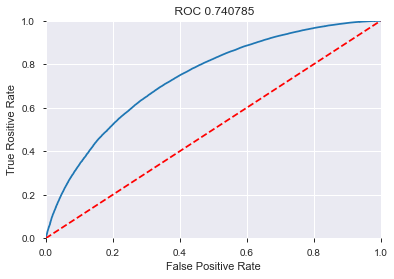

In [383]:
plot_roc_auc(y_train_undersampling, model_LR.predict_proba(X_train_undersampling_free_outlier)[:, 1])

In [384]:
print_metrics(y_test, model_LR.predict(X_test))

accuracy: 0.6959893840425669
MSE: 0.3040106159574331
MAE: 0.3040106159574331
f1 score: 0.6129926360848245
precision score: 0.5852986313382819
recall score: 0.643437543038149


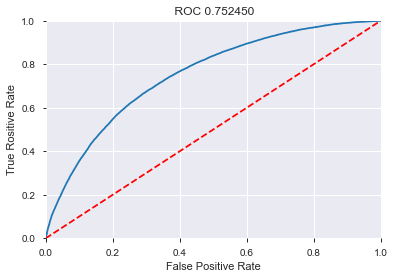

In [385]:
plot_roc_auc(y_test, model_LR.predict_proba(X_test)[:, 1])

### -------------SVC--------------------

In [59]:
from sklearn.model_selection import GridSearchCV

In [60]:
from sklearn.svm import SVC

In [109]:
count_index = int(X_train.shape[0] / 10)

In [110]:
index_True = y_train[y_train == 1].index
index_False = y_train[y_train == 0].index

In [111]:
index_True = np.random.choice(index_True, count_index, replace=False)
index_False = np.random.choice(index_False, count_index, replace=False)
index_True_False = np.append(index_True, index_False)

In [112]:
X_train_svc = X_train.loc[index_True_False]
X_train_svc.sort_index(inplace=True)

y_train_svc = y_train[index_True_False]
y_train_svc.sort_index(inplace=True)

In [113]:
False in (X_train_svc.index == y_train_svc.index)

False

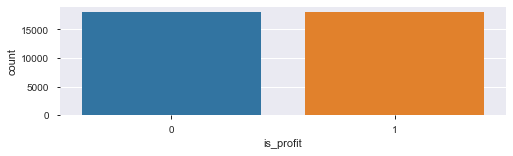

In [114]:
plt.figure(figsize=(8, 2))
sns.countplot(y_train_svc);

In [115]:
model_svc = SVC()

In [116]:
params_grid = {'kernel': ['linear', 'rbf']}

In [117]:
svr = GridSearchCV(estimator=model_svc, param_grid=params_grid, cv=3, n_jobs=-1)

In [118]:
%%time
model_svc.fit(X_train_svc, y_train_svc)

CPU times: user 2min 28s, sys: 84 ms, total: 2min 28s
Wall time: 2min 28s


SVC()

In [434]:
%%time
svr.fit(X_train_svc, y_train_svc)
#model_svc.fit(X_train, y_train)

CPU times: user 1min 7s, sys: 32 ms, total: 1min 7s
Wall time: 8min 8s


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.0001, 0.01, 1.0, 10.0, 100.0]})

In [435]:
svr.best_params_

{'C': 1.0}

In [436]:
svr.best_params_

{'C': 1.0}

In [104]:
model_svc = SVC(kernel='rbf', random_state=42)

In [105]:
params_grid = {'C': [0.5, 2.0, 5.0]}

In [106]:
svr = GridSearchCV(estimator=model_svc, param_grid=params_grid, cv=3, n_jobs=-1)

In [107]:
%%time
svr.fit(X_train_svc, y_train_svc)

CPU times: user 20.3 s, sys: 136 ms, total: 20.4 s
Wall time: 1min 10s


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.5, 2.0, 5.0]})

In [108]:
svr.best_params_

{'C': 0.5}

In [194]:
model_svc = SVC(kernel='rbf', C=1.0, random_state=42)

In [198]:
params_grid = {"gamma": [-100.0, -10.0, 1.0, 10.0, 100.0]}

In [199]:
svr = GridSearchCV(estimator=model_svc, param_grid=params_grid, cv=3, n_jobs=-1)

In [200]:
svr

GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'gamma': [-100.0, -10.0, 1.0, 10.0, 100.0]})

In [201]:
%%time
svr.fit(X_train_short, y_train_short)

CPU times: user 6min 50s, sys: 408 ms, total: 6min 50s
Wall time: 16min 30s


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'gamma': [-100.0, -10.0, 1.0, 10.0, 100.0]})

In [202]:
svr.best_params_

{'gamma': 10.0}

In [215]:
model_svc = SVC(kernel='rbf', C=1.0, random_state=42)

params_grid = {"gamma": [1.5, 2.0, 2.5, 3.0]}

svr = GridSearchCV(estimator=model_svc, param_grid=params_grid, cv=3, n_jobs=-1)

svr

GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'gamma': [1.5, 2.0, 2.5, 3.0]})

In [216]:
%%time
svr.fit(X_train_short, y_train_short)

CPU times: user 7min 11s, sys: 544 ms, total: 7min 11s
Wall time: 21min 28s


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'gamma': [1.5, 2.0, 2.5, 3.0]})

In [217]:
svr.best_params_

{'gamma': 2.5}

#### model svc -> kerner = rbf , C = 1.0, gamma = 2.5

In [93]:
model_svc_final = SVC(kernel='rbf', C=1.0, gamma=2.5, probability=True)

In [ ]:
%%time
model_svc_final.fit(X_train, y_train)

In [ ]:
%%time
y_pred_train = model_svc_final.predict(X_train)

In [ ]:
print_metrics(y_train, y_pred_train)

In [ ]:
%%time
y_pred_test = model_svc_final.predict(X_test)

In [ ]:
print_metrics(y_test, y_pred_test)

In [ ]:
%%time
plot_roc_auc(y_test, model_svc_final.predict_proba(X_test)[:, 1], title='TEST')

In [79]:
svr.best_params_

{'kernel': 'rbf'}

In [177]:
index = X_train.index

In [178]:
index_short = [i for i in index[::5]]

In [179]:
X_train_short = X_train.loc[index_short]

In [180]:
y_train_short = y_train[index_short]

In [84]:
params = {'C': [0.001, 0.1, 1, 10, 100]}

In [85]:
model_svc = SVC(kernel='rbf')

In [101]:
gsv = GridSearchCV(estimator=model_svc, param_grid=params, cv=3, n_jobs=-1)

In [87]:
%%time
gsv.fit(X_train_short, y_train_short)

CPU times: user 2min 27s, sys: 284 ms, total: 2min 28s
Wall time: 22min 45s


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.1, 1, 10, 100]})

In [115]:
y_train_short.shape, X_train_short.shape

((64682,), (64682, 24))

In [102]:
gsv.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [94]:
model_svc = SVC(kernel='rbf', C=1.0)

In [87]:
params = {'gamma': [0.001, 0.1, 1, 10, 100, 1000]}

In [95]:
gsv = GridSearchCV(estimator=model_svc, param_grid=params, cv=3, n_jobs=-1)

In [97]:
%%time
model_svc.fit(X_train_short, y_train_short)

CPU times: user 3min 3s, sys: 128 ms, total: 3min 3s
Wall time: 3min 3s


SVC()

In [96]:
gsv

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'gamma': [0.001, 0.1, 1, 10, 100, 1000]})

In [218]:
gsv.get_params_

AttributeError: 'GridSearchCV' object has no attribute 'get_params_'

In [ ]:
y_pred = model_svc.predict(X_train)

In [ ]:
print_metrics(y_train, y_pred)

In [7]:
a = np.c_[1:5]
b = np.c_[10:50:10]

In [9]:
np.c_[a, b].var()

189.6875

In [87]:
index_short_train = np.random.choice(index_train, 20000)

NameError: name 'index_train' is not defined

In [88]:
len(index_short_train)

20000

In [89]:
X_train_short = X_train.loc[index_short_train]

In [90]:
X_train_short.sort_index(inplace=True)

In [91]:
y_train_short = y_train.loc[index_short_train]

In [92]:
y_train_short.sort_index(inplace=True)

In [93]:
np.sum(y_train_short.index == X_train_short.index)

20000

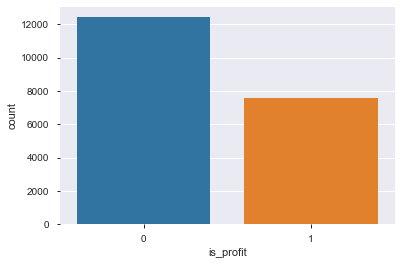

In [94]:
sns.countplot(y_train_short)

In [132]:
model_svc = SVC()

In [130]:
%%time
model_svc.fit(X_train_short, y_train_short)

CPU times: user 29.4 s, sys: 96 ms, total: 29.5 s
Wall time: 29.5 s


SVC()

In [120]:
y_pred = model_svc.predict(X_test)

In [121]:
accuracy_score(y_test, y_pred)

0.36276919747074193

In [158]:
x = ds.sort_index().index
y = range(len(x))

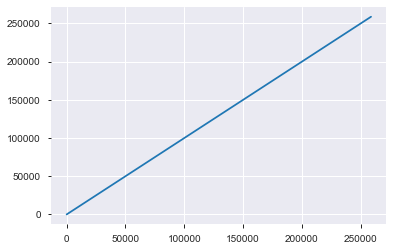

In [159]:
plt.plot(x, y);

In [164]:
index_for_short = [v for v in x[::10]]
X_train_short = ds.loc[index_for_short]

In [165]:
X_train_short

,is_profit,sym,datetime,rsi14,sma9_var,sma180_var,vwap_var,spread14_e,volume14_34_var,prev_close_var,...,prev2_candle_score,prev3_candle_score,mins_from_start,valley_interval_mins,valley_close_score,valley_rsi_score,day_open_var,open_from_prev_close_var,ceil_var,floor_var
0,True,MGNX,2020-11-02 11:13:00,30.509761,-0.006223,-0.022679,-0.017526,0.000620,-0.006472,-0.037037,...,0.000000,0.000000,103.0,50.0,0.425532,0.758046,-0.032058,-0.005144,-0.034554,0.000802
10,True,BLNK,2020-11-02 14:11:00,45.629119,-0.001515,-0.013328,-0.015379,0.000450,0.276878,0.018084,...,0.000000,-0.001261,281.0,58.0,0.553183,15.230913,-0.024661,0.043825,-0.030637,0.003807
20,False,SMAR,2020-11-02 13:11:00,32.521222,-0.001613,-0.013340,-0.014689,0.000364,-0.076646,-0.014234,...,-0.000102,-0.000305,221.0,22.0,0.067683,2.201373,-0.014827,0.000601,-0.037581,0.000000
30,True,PS,2020-11-02 13:23:00,38.472459,-0.002767,-0.017476,-0.016722,0.001334,-0.829735,0.007643,...,0.001899,-0.001577,233.0,10.0,0.126266,6.540503,-0.002207,0.009873,-0.031231,0.004444
40,True,SHAK,2020-11-02 10:51:00,38.905403,-0.001339,-0.032060,-0.011469,0.001067,-0.075535,-0.049576,...,0.000000,0.000778,81.0,6.0,0.011531,2.949118,-0.041485,-0.008442,-0.041485,0.001914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258680,True,FULT,2021-01-22 09:40:00,35.348826,-0.005714,-0.009876,-0.003359,0.002311,0.046203,-0.003506,...,-0.001395,0.002098,10.0,9.0,0.070325,18.800343,-0.003506,0.000000,-0.008374,0.000000
258690,False,JD,2021-01-22 13:29:00,31.379597,-0.000955,-0.004431,-0.000979,0.000412,0.179564,-0.004731,...,0.000252,0.000211,239.0,10.0,0.021018,4.763803,0.005739,-0.010410,-0.009097,0.009170
258700,False,GOEV,2021-01-22 10:29:00,42.564584,-0.002300,-0.008094,-0.002215,0.001492,-0.242891,-0.009947,...,0.002952,-0.000443,59.0,10.0,0.052571,0.770240,-0.004132,-0.005840,-0.009368,0.003463
258710,False,PIPP,2021-01-22 11:28:00,40.807732,-0.002307,-0.009014,-0.010942,0.001348,-0.124533,-0.003864,...,-0.001161,0.001301,118.0,23.0,0.077514,6.924233,0.003113,-0.006955,-0.024224,0.004543


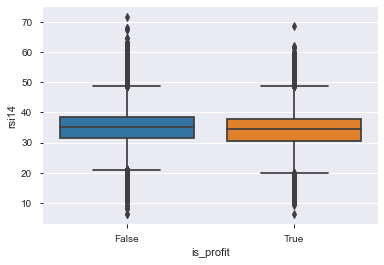

In [170]:
sns.boxplot(y='rsi14', x='is_profit', data=ds)

In [133]:
params_grid = {'kernel': ['linear', 'rbf', 'poly'], 'C': [1e0, 1e1, 1e2, 1e3],
              'gamma': np.logspace(-2, 2, 5)}

In [134]:
%%time
svr = GridSearchCV(model_svc, params_grid, cv=5, n_jobs=-1)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 95.6 µs


In [135]:
%%time
svr.fit(X_train, y_train)

KeyboardInterrupt: 

In [136]:
svr.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
y_pred_train = svr.best_params(X_train)

In [ ]:
accuracy_score(y_train, y_pred_train)